# Find the fingerprints of ENSO and the IPO in observed gridded datasets

Purpose
-------

    1.    Decompose the temperature time series into Intrinsic Mode Functions (IMFs) using EMD.
            i)  remove monthly climatology
            ii) remove linear trend over timeseries
    2.    Identify and correlate relevant IMFs with known indices for ENSO and IPO.
    3.    Compute slope of relationship between ENSO/IPO and variable of interest to quantify effect of ENSO/IPO


### IMPORTS

In [7]:

import sys
import os
import glob
import warnings

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# oceanographic
import gsw as gsw

# statistics
import scipy as sci
from scipy.signal import hilbert, periodogram
from PyEMD import EMD, CEEMDAN

# regridding package
import xesmf as xe

# Copernicus marine toolbox
#import copernicusmarine
#from pprint import pprint
#copernicusmarine.login()

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sci.__version__)
print("xarray version =", xr.__version__)
print("xesmf version =", xe.__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)


wrkdir="/g/data/es60/pjb581/SPC"
os.chdir(wrkdir)
os.getcwd()


python version = 3.10.
numpy version = 2.1.3
pandas version = 2.2.3
scipy version = 1.15.1
xarray version = 2024.11.0
xesmf version = 0.8.8
cartopy version = 0.24.1
matplotlib version = 3.10.0
cmocean version = v3.0.3


'/g/data/es60/pjb581/SPC'

## Load the oxygen 200m dataset

In [8]:
%%time

oxy = xr.open_dataset("/g/data/es60/pjb581/SPC/data/GOBAIv2.2_oxy200m_2004-2023.nc")['oxy200m']
oxy


CPU times: user 21 ms, sys: 532 μs, total: 21.5 ms
Wall time: 18.7 ms


<xarray.DataArray 'oxy200m' (time: 240, lat: 145, lon: 360)> Size: 50MB
[12528000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 580B -64.5 -63.5 -62.5 -61.5 ... 76.5 77.5 78.5 79.5
  * time     (time) datetime64[ns] 2kB 2004-01-15 2004-02-15 ... 2023-12-15
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Attributes:
    long_name:      Dissolved Oxygen Concentration
    units:          micromoles per kilogram
    source:         machine learning scheme decribed in Sharp et al. (submitted)
    standard_name:  mole_concentration_of_dissolved_molecular_oxygen_in_sea_w...

In [9]:
%%time

# Assume oxy200m is already loaded and is a DataArray
#oxy = oxy.where(np.isfinite(oxy), -9999.0)
#oxy = oxy.astype("float32")

# Set CF-compliant coordinate attributes
oxy.coords["lat"].attrs = {
    "standard_name": "latitude",
    "long_name": "Latitude",
    "units": "degrees_north",
    "axis": "Y"
}
oxy.coords["lon"].attrs = {
    "standard_name": "longitude",
    "long_name": "Longitude",
    "units": "degrees_east",
    "axis": "X"
}
oxy.coords["time"].attrs = {
    "standard_name": "time",
    "long_name": "Time",
    "axis": "T"
}

# Optional: update variable name (if desired)
oxy.name = "oxygen_200m"

# Save to NetCDF with proper encoding
os.chdir(wrkdir + "/data")
oxy.to_netcdf(
    "oxygen_200m_clean.nc",
    format="NETCDF4",
    encoding={
        "oxygen_200m": {
            "dtype": "float32",
            "zlib": True,
            "complevel": 4,
            "_FillValue": -9999.0
        }
    }
)


CPU times: user 925 ms, sys: 77.4 ms, total: 1 s
Wall time: 1.08 s


## Take the monthly anomaly in MLDs

CPU times: user 136 ms, sys: 109 ms, total: 245 ms
Wall time: 452 ms


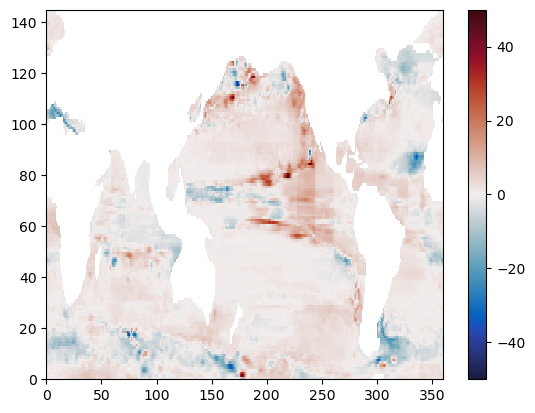

In [3]:
%%time

oxy_clim = oxy.groupby('time.month').mean('time')
oxy_anom = oxy.groupby('time.month') - oxy_clim

plt.figure()
plt.pcolormesh(oxy_anom.isel(time=0), cmap=cmo.balance, vmin=-50, vmax=50)
plt.colorbar()


## detrend the MLD dataset

In [5]:
%%time

### remove global trend
def detrend_1d(arr):
    """Remove the linear trend from a 1D array."""
    x = np.arange(len(arr))
    # Fit a linear trend
    coeffs = np.polyfit(x, arr, 1)
    trend = np.polyval(coeffs, x)
    # Remove the trend
    detrended = arr - trend
    return detrended

oxy_detr = xr.apply_ufunc(
    detrend_1d,
    oxy_anom,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[oxy_anom.dtype]
)



CPU times: user 7.43 s, sys: 590 ms, total: 8.02 s
Wall time: 7.27 s


## determine the linear trends since 2005

CPU times: user 174 ms, sys: 33.8 ms, total: 208 ms
Wall time: 205 ms


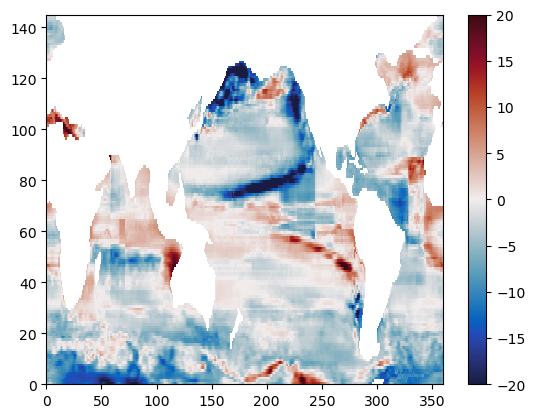

In [6]:
%%time

### retrive the linear least squares trend
oxy_trend = oxy_anom - oxy_detr

### since the trends are linear, they can be described by one number (their slope)
### calculate the slope on a decadal timescale
dates = oxy_anom.coords['time']
oxy_trend = oxy_trend.sel(time=dates[-1]) - oxy_trend.sel(time=dates[0]) / len(dates) * 12 * 10

plt.figure()
plt.pcolormesh(oxy_trend, cmap=cmo.balance, vmin=-20, vmax=20)
plt.colorbar()


## Undertake the decomposition at each grid cell across the ocean

In [7]:
%%time
from joblib import Parallel, delayed
import signal

# Setup CEEMDAN config
def make_ceemdan():
    ceemdan = CEEMDAN()
    ceemdan.noise_seed = 42
    ceemdan.num_siftings = 100
    ceemdan.Nstd = 0.2
    ceemdan.trials = 100
    return ceemdan

# Setup
years = np.arange(2005+0.5/12, 2024+11.51/12, 1/12)
times = oxy_anom.coords['time'].values
lats = oxy_anom.coords['lat'].values
lons = oxy_anom.coords['lon'].values

def find_imf_freq_Hilbert(imfs, years):
    inst_freqs = []
    for imf in imfs:
        analytic_signal = hilbert(imf)
        amplitude_envelope = np.abs(analytic_signal)
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
        instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi * np.diff(years))
        inst_freqs.append(instantaneous_frequency)
    return np.array([np.mean(freq) for freq in inst_freqs])

def find_weights_from_freqs(imfs, bands):
    fs = 12  # Hz (cycles per year)
    n_imfs, n_time = imfs.shape
    n_bands = len(bands)
    weights = np.zeros((n_bands, n_imfs))
    # find the frequency power spectra of the different IMFs
    freqs = []
    power = []
    for i in range(n_imfs):
        f, p = periodogram(imfs[i,:], fs=fs, scaling='density', window='hann')
        freqs.append(f)
        power.append(p)
    freqs = np.array(freqs); power = np.array(power)
    # find the weights associated with that power spectra
    for i in range(n_imfs):
        total_power = np.sum(power[i,:])
        for j, (f_min, f_max) in enumerate(bands):
            mask = (freqs[i,:] >= f_min) & (freqs[i,:] < f_max)
            band_power = np.sum(power[i][mask])
            weights[j, i] = band_power / total_power if total_power > 0 else 0.0
    return weights

def set_bands(imfs, weights):
    return weights @ imfs

# Processing function for each grid cell
def process_cell(ix, iy):
    ceemdan = make_ceemdan()  # Create fresh CEEMDAN instance (safe in parallel)
    signal = oxy_detr.isel(lon=ix, lat=iy).values
    if not np.all(np.isfinite(signal)) or np.all(signal == 0.0):
        return (ix, iy, None)
    try:
        imfs = ceemdan(signal)
        weights = find_weights_from_freqs(imfs, bands)
        grouped = set_bands(imfs, weights)
        return (ix, iy, grouped)
    except Exception as e:
        print(f"Error at ({ix}, {iy}): {e}")
        return (ix, iy, None)


CPU times: user 30.8 ms, sys: 32.1 ms, total: 62.8 ms
Wall time: 194 ms


## run for z20

In [8]:
%%time

# Predefined cut-offs for frequency bands
bands = [
    (1.0, np.inf),       # Subannual
    (0.15, 1.0),         # Interannual
    (0.01, 0.15),        # Decadal
    (-np.inf, 0.01)       # Centennial or more
]

# Coordinate pairs
ntime = len(times)
nlat = len(lats)
nlon = len(lons)
coords = [(ix, iy) for ix in range(nlon) for iy in range(nlat)]

# Run in parallel
results = Parallel(n_jobs=56, backend='loky', verbose=10)(
    delayed(process_cell)(ix, iy) for (ix, iy) in coords
)


[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=56)]: Done   1 tasks      | elapsed:    8.2s
[Parallel(n_jobs=56)]: Done  16 tasks      | elapsed:   11.4s
[Parallel(n_jobs=56)]: Done  33 tasks      | elapsed:   11.5s
[Parallel(n_jobs=56)]: Done  50 tasks      | elapsed:   11.7s
[Parallel(n_jobs=56)]: Done  69 tasks      | elapsed:   11.8s
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:   13.4s
[Parallel(n_jobs=56)]: Done 109 tasks      | elapsed:   15.9s
[Parallel(n_jobs=56)]: Done 130 tasks      | elapsed:   18.3s
[Parallel(n_jobs=56)]: Done 153 tasks      | elapsed:   20.7s
[Parallel(n_jobs=56)]: Done 176 tasks      | elapsed:   22.0s
[Parallel(n_jobs=56)]: Done 201 tasks      | elapsed:   22.4s
[Parallel(n_jobs=56)]: Done 226 tasks      | elapsed:   24.1s
[Parallel(n_jobs=56)]: Done 253 tasks      | elapsed:   26.9s
[Parallel(n_jobs=56)]: Done 280 tasks      | elapsed:   30.4s
[Parallel(n_jobs=56)]: Done 309 tasks      | elapsed:  

CPU times: user 2min 24s, sys: 8.77 s, total: 2min 33s
Wall time: 1h 4min 58s


In [9]:
%%time

oxy_imfs = np.zeros((4,len(times),len(lats),len(lons)))

# Assemble results
for ix, iy, grouped in results:
    if grouped is not None:
        oxy_imfs[:, :, iy, ix] = grouped



CPU times: user 451 ms, sys: 224 ms, total: 675 ms
Wall time: 672 ms


In [10]:
%%time

# Create xarray Datasets
imfs_oxy_ds = xr.Dataset(
    {
        "oxy_imfs": (["IMF", "time", "lat", "lon"], oxy_imfs),
        "oxy_anom": (["time", "lat", "lon"], oxy_anom.values),
        "oxy_detr": (["time", "lat", "lon"], oxy_detr.transpose("time", "lat", "lon").values),
        "oxy_trend": (["lat", "lon"], oxy_trend.values),
    },
    coords={
        "IMF": np.arange(1,5,1),
        "time": dates,
        "lat": lats,
        "lon": lons,
    },
)
os.chdir(wrkdir + "/data/")
#os.remove("imfs_oxy_CEEMDAN.nc")
imfs_oxy_ds.to_netcdf("imfs_oxy_CEEMDAN.nc")


CPU times: user 326 ms, sys: 854 ms, total: 1.18 s
Wall time: 1.83 s
